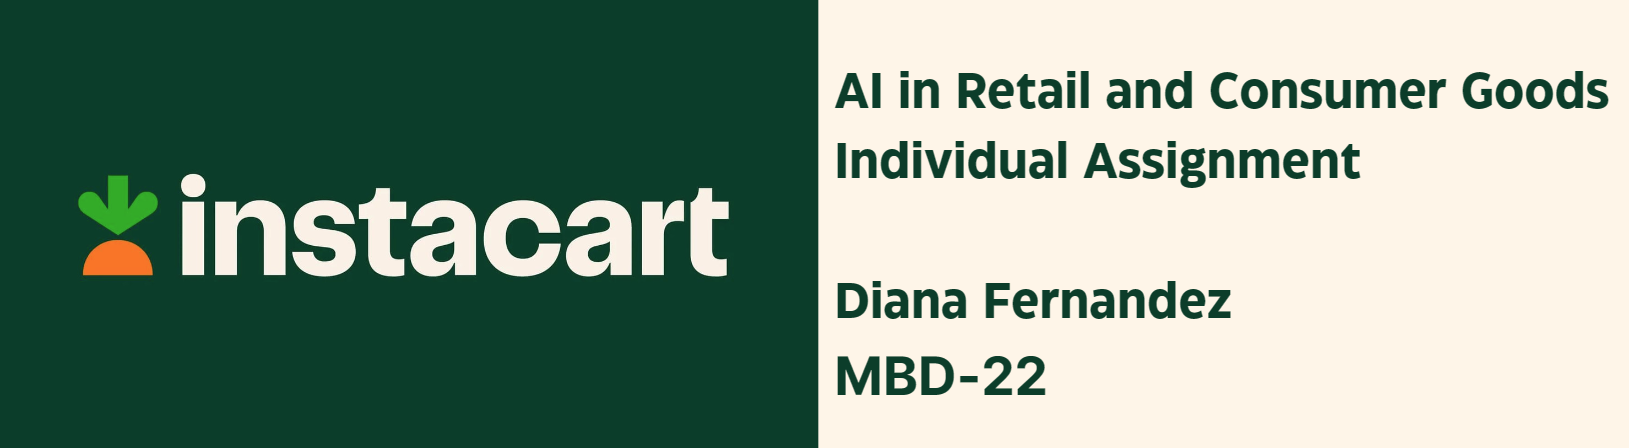

# Instacart Recommendation Engine

This Jupyter notebook aims to build a recommendation engine using vector embeddings. The recommendation engine will utilize various features such as product names, shopping cart and user behaviour to generate relevant recommendations for users.

The notebook is organized into the following sections:

0. Flowchart
1. Initial Setup: Loading necessary libraries and dependencies.
2. Data Loading and Pre-processing: Loading and preparing the required data for the recommendation engine.
3. Applying NLP techniques to product names: Stemmization and Lemmatization.
4. Build Vector Embeddings: Creating vector embeddings for different features based on order carts.
    - 4a. Build Product Embedding by Name: Vector representation for stem word.
    - 4b. Build Product Embedding by Cart: Vector representation for product (id).
    - 4c. Build Product Embedding by Department: Vector representation by Department.
5. Concatenate Embeddings & Generate Representations: Combining the vector embeddings from the previous steps, generate representations for each order/user by averaging all product vectors in the order/ever ordered by user
6. Vector Similarity Search (Output): Using the concatenated embeddings to perform similarity search and generate recommendations.
7. Saving objects

A separated notebook has been created for EDA purposes.

# 0. Flowchart

![Screenshot 2023-06-22 145643.png](<attachment:Screenshot 2023-06-22 145643.png>)
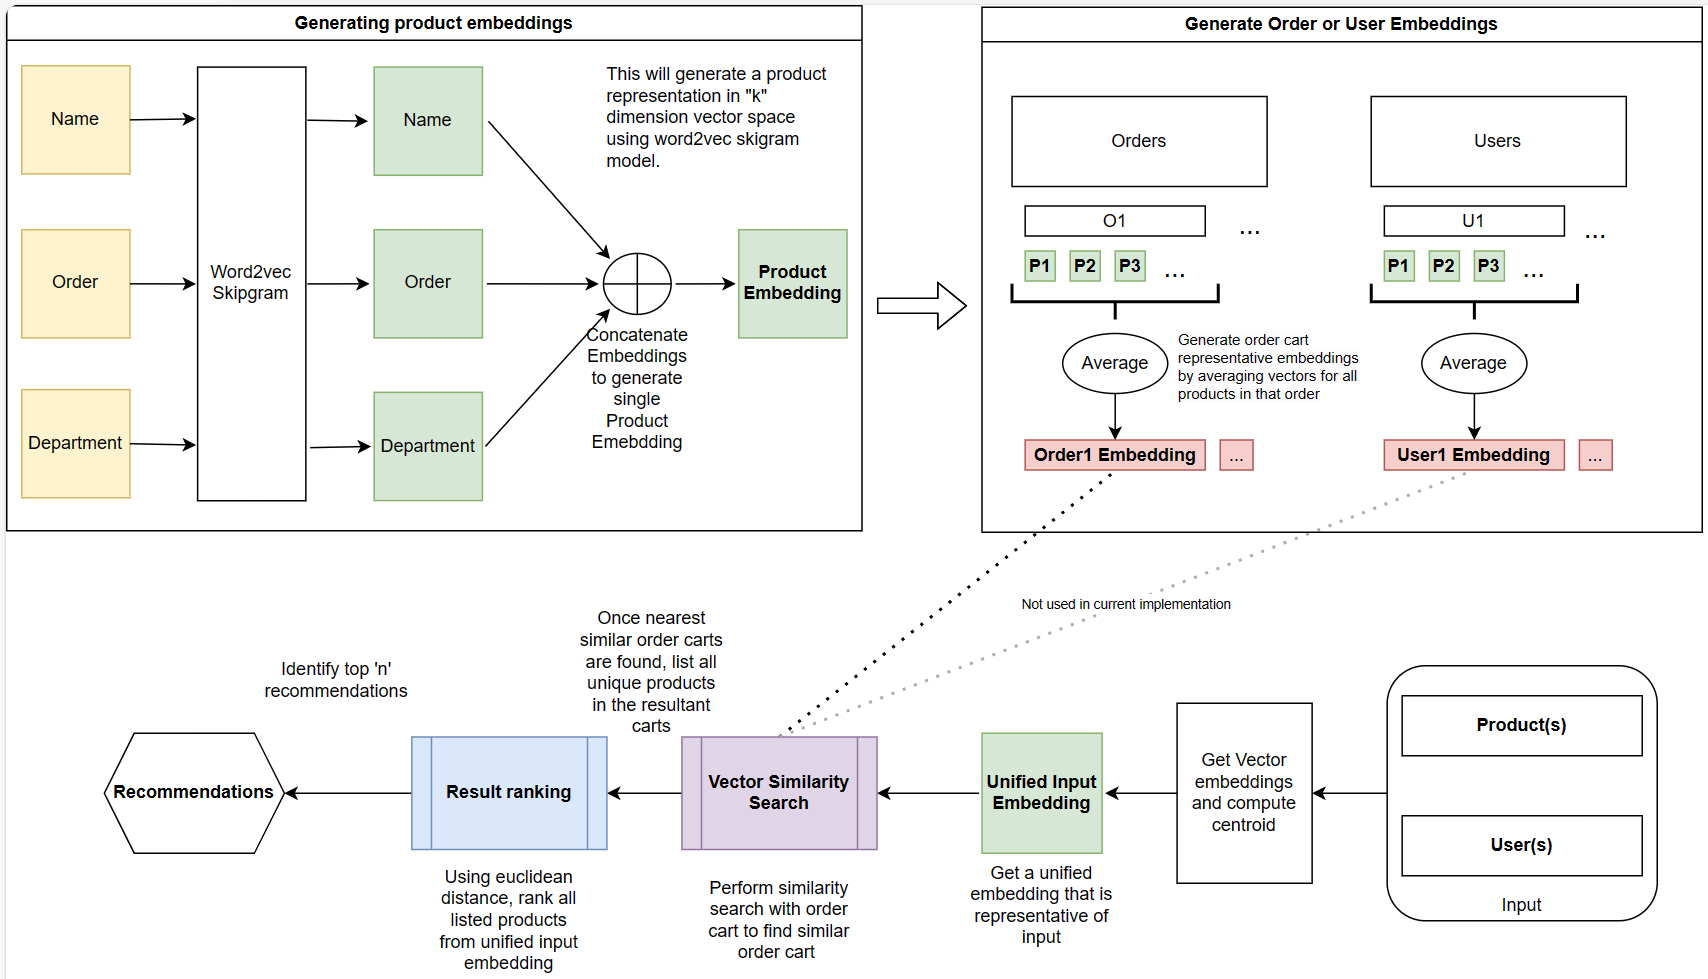

## 1. Initial Setup: Loading necessary libraries and dependencies

In [22]:
!pip install gensim
!pip install annoy
!pip install nltk


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\dianaf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\dianaf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\dianaf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
import os

import numpy as np
import pandas as pd
from pandas.core.common import flatten

from gensim.models import Word2Vec
import seaborn as sns

from annoy import AnnoyIndex

import nltk
nltk.download('wordnet')

from tqdm import tqdm
import zipfile as zp
from art import *
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import plotly.express as px

# from PyDictionary import PyDictionary P
import random
import time

#import scikitplot as skplt

#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dianaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Change to location of data (Instacart Market Basket Analysis Kaggle data)
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

## 2. Data Loading and Pre-processing: Loading and preparing the required data for the recommendation engine.

In [25]:
# Reading the csv files into corresponding dataframes
aisles = pd.read_csv("datasets/aisles.csv")
order_products_prior = pd.read_csv("datasets/order_products__prior.csv")
order_products_train = pd.read_csv("datasets/order_products__train.csv")
products = pd.read_csv("datasets/products.csv")
orders = pd.read_csv("datasets/orders.csv")
departments = pd.read_csv("datasets/departments.csv")

# Replacing numbers with their corresponding day of week
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week)
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))

orders['daytime'] = orders['order_dow'].astype('str') + orders['order_hour_of_day'].astype('str')

## 3. Applying NLP techniques to product names: Stemmization and Lemmatization.

In [26]:
## Product name stemming and lemmatisation
products['products_mod'] = products['product_name'].str.lower()
# Clean special characters.
products['products_mod'] = products['products_mod'].str.replace('\W', ' ', regex=True)
# Split products into terms: Tokenize.
products['products_mod'] = products['products_mod'].str.split()
# Merge the department and aisle names into the dataframe. 
products = pd.merge(products, departments, on="department_id", how='outer')
products = pd.merge(products, aisles, on="aisle_id", how='outer')
# Remove synonyms here in the list
products['products_mod'] = products[['products_mod', 'aisle', 'department']].values.tolist()
products['products_mod'] = products['products_mod'].apply(lambda x:list(flatten(x)))

lemma = nltk.wordnet.WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')
products['products_lemma'] = products['products_mod'].apply(lambda row:[lemma.lemmatize(item) for item in row])
products['products_lemma'] = products['products_lemma'].apply(lambda row:[sno.stem(item) for item in row])

prod_dict = dict(zip(products.product_id, products.product_name))

In [27]:
## Add product information to order_products_prior
order_products_prior = order_products_prior.merge(products[['product_id', 'department_id', 'aisle_id']], on='product_id')
## Group all products for a single order into a list
## This will be later used to generate embeddings
order_baskets = order_products_prior.groupby('order_id')['product_id'].apply(list)

In [28]:
%%time
# Generate department and aisle baskets
department_basket = order_products_prior.groupby('order_id')['department_id'].apply(list)
aisle_basket = order_products_prior.groupby('order_id')['aisle_id'].apply(list)

department_basket_unique = department_basket.apply(lambda x: list(set(x)))
aisle_basket_unique = aisle_basket.apply(lambda x: list(set(x)))

CPU times: total: 1min 32s
Wall time: 2min 7s


## 4. Build Vector Embeddings: Creating vector embeddings for different features based on order carts.

In [29]:
## Configuration

# Vector size for word embeddings
# Justification: A vector size of 8 strikes a balance between capturing semantic information and manageable dimensionality.
WORD_VECTOR_SIZE = 8
# Vector size for product embeddings
# Justification: A vector size of 64 allows for capturing complex relationships and characteristics of the products.
PRODUCT_VECTOR_SIZE = 64
# Vector size for department embeddings
# Justification: A vector size of 2 effectively represents the limited number of department categories with low computational complexity.
DEPARTMENT_VECTOR_SIZE = 2
# CPU Cores
WORKER_COUNT = os.cpu_count()
# Minimum frequency before dropping set to 1 to include each and every product, even if it was purchased once
MIN_COUNT = 1

In [30]:
### Training the `Word2Vec` model based on product lemma
# Defining the maximun window
window_max = max(products['products_lemma'].apply(lambda x:len(x)))

# size=20: In order to make `Word2Vec` a little bit quicker and for memory efficiency we're going to use 20 dimensions.
# window=49: In order to make sure all words are used in training the model, we're going to set a large.
w2vec_model = Word2Vec(list(products['products_lemma']), vector_size=WORD_VECTOR_SIZE, window=window_max,
                       min_count=MIN_COUNT, workers=WORKER_COUNT)

### Vector calculation for products
# Loop through each product and obtain the average of each string that makes a product.
# This will be the vector representation of the product.
# The vector representation of the product will be used to calculate the similarity between products.
# The similarity between products will be used to recommend products to the user.

# Loop through each word in the product name to generate the vector.
prods_w2v = dict()
for row, product in tqdm(products.iterrows()):
    word_vector = list()
    for word in product['products_lemma']:
        word_vector.append(w2vec_model.wv[word])

    prods_w2v[product['product_id']] = np.average(word_vector, axis=0)

# Save vector values in list form to the dataframe.
products['vectors_word'] = prods_w2v.values()

49688it [00:06, 7529.46it/s] 


In [31]:
%%time
### Training the `Word2Vec` model based on cart
# products which are ordered together will be closer in vector space

# Define maximum window for longest order cart
window_max = order_baskets.apply(len).max()

# w2vec model
w2vec_model = Word2Vec(list(order_baskets), vector_size=PRODUCT_VECTOR_SIZE, window=window_max,
                       min_count=MIN_COUNT, workers=WORKER_COUNT)

# get vectors for each product
products['vectors_product'] = products.product_id.apply(lambda x: w2vec_model.wv[x])

CPU times: total: 54.1 s
Wall time: 1min 20s


In [32]:
%%time
# # Define maximum window for longest order cart
window_max = department_basket.apply(len).max()

# w2vec model
w2vec_model = Word2Vec(list(department_basket), vector_size=DEPARTMENT_VECTOR_SIZE, window=window_max, 
                       min_count=MIN_COUNT, workers=WORKER_COUNT)

# get vectors for each product
products['vectors_dept'] = products.department_id.apply(lambda x: w2vec_model.wv[x])

CPU times: total: 11.4 s
Wall time: 53.9 s


## 5. Concatenate Embeddings & Generate Representations: Combining the vector embeddings from the previous steps, generate representations for each order/user by averaging all product vectors in the order/ever ordered by user

In [33]:
## Using `annoy` model to calculate the similarity between products
def annoy_build(df, id, vector_size, metric='euclidean'):
    trees = 10
    m = AnnoyIndex(vector_size, metric=metric) 
    m.set_seed(42)
    for _, row in df.iterrows():
        m.add_item(row[id], row['vectors'])
    m.build(trees)
    return m

In [34]:
## Concatenate all vectors together to form a single representation of product embedding
products['vectors'] = products.apply(lambda x: [*x['vectors_word'], *x['vectors_product'], *x['vectors_dept']], axis=1)

In [35]:
%%time
### Train `annoy` for `product` dataset
### Annoy object can be used to identify similar products for a given product embedding
p = annoy_build(products, 'product_id', len(products['vectors'][0]))

CPU times: total: 2.14 s
Wall time: 3.72 s


In [36]:
%%time
### Train `annoy` for `orders` dataset
### Annoy object can be used to identify similar orders for a given embedding
order_w2v = dict()
for index, row in tqdm(order_baskets.items()):
    word_vector = list()
    for item_id in row:
        word_vector.append(p.get_item_vector(item_id))
    order_w2v[index] = np.average(word_vector, axis=0)

df_order_baskets = pd.DataFrame({'order_id': order_baskets.index, 'product_id': order_baskets.values})
df_order_baskets['vectors'] = order_w2v.values()

# Specify the metric to be used for computing distances. 
b = annoy_build(df_order_baskets, 'order_id', len(df_order_baskets['vectors'][0]))

3214874it [03:53, 13765.29it/s]


CPU times: total: 8min 26s
Wall time: 7min 19s


In [37]:
%%time
def func_avg(x):
    return np.average(x, axis=0)

### Train `annoy` for `orders` dataset
### Annoy object can be used to identify similar users for a given embedding

user_basket = pd.merge(df_order_baskets, orders, on="order_id", how='inner')

df_user_basket = user_basket[['user_id', 'vectors', 'product_id']]
df_user_basket = df_user_basket.groupby('user_id').agg(list)
df_user_basket['vectors'] = df_user_basket['vectors'].agg(func_avg).apply(tuple)
df_user_basket['product_id'] = df_user_basket['product_id'].agg(lambda x: list(set([item for sublist in x for item in sublist])))
df_user_basket = df_user_basket.reset_index()

# Specify the metric to be used for computing distances. 
u = annoy_build(df_user_basket, 'user_id', len(df_user_basket.vectors[0]))

CPU times: total: 39.8 s
Wall time: 33.3 s


## 6. Vector Similarity Search (Output): Using the concatenated embeddings to perform similarity search and generate recommendations.

Inputs can be of multiple types
1. Only products input - Get centroid vector of products, then find carts that are similar and rank products
2. Only user_ids input - Get centroid vector of user_ids, then find carts that are similar and rank products
3. Both products and user_ids as input - Get products and user centroid, then find products by product and dot product with user centroid to find best products
4. No input - Find products based on daytime

In [38]:
product_list = [47136, 2529, 8990]
user_list = [1,2,3]
daytime = 127

In [39]:
def rank_by_euclidean(df, vector):
    df['distance'] = df['vectors'].apply(lambda x: np.linalg.norm(x - vector))
    df = df.sort_values('distance', ascending=False)
    return df

def rank_by_dot_product(df, vector):
    df['dot_prod'] = df['vectors'].apply(lambda x: np.dot(x, vector))
    df = df.sort_values('dot_prod', ascending=False)
    return df

def compose_basket_by_cart(product_vector, input = None, n_items = 15, method='euclidean', n_neighbours = 100):
    order_list = b.get_nns_by_vector(product_vector, n_items)
    fpl = []
    for order in order_list:
        fpl = fpl + order_baskets[order]
    
    fpl = list(set(fpl))

    sel_df = pd.DataFrame({"product_id": fpl}).merge(products, on='product_id', how='inner')
    if method == 'euclidean':
        sel_df = rank_by_euclidean(sel_df, product_vector)
    else:  
        sel_df = dot_prod_rank(sel_df, product_vector)
    if input is not None:
        sel_df = sel_df[~sel_df.product_id.isin(input)]
    sel_df = sel_df[['product_name', 'department', 'aisle']].head(n_items).reset_index(drop=True)
    return sel_df

In [40]:
def get_centroid(vector_list):
    return np.average(vector_list, axis=0)

def get_centroid_by_annoy_obj(obj_ann, obj_list):
    w2v_list = []
    for obj_id in obj_list:
        w2v_list.append(obj_ann.get_item_vector(obj_id))
    return get_centroid(w2v_list)

def get_basket_by_product_list(product_list, n_items = 15):
    selected = products[products.product_id.isin(product_list)]
    prod_vector = get_centroid(selected.vectors.tolist())
    return compose_basket_by_cart(prod_vector, input=selected.product_name.tolist(), n_items=n_items)

def get_basket_by_user_list(user_list, n_items = 15):
    user_vector = get_centroid_by_annoy_obj(u, user_list)
    return compose_basket_by_cart(user_vector, n_items=n_items)

def get_basket_by_user_product(product_list, user_list, n_items = 15):
    # Get product vector
    selected = products[products.product_id.isin(product_list)]
    prod_vector = get_centroid(selected.vectors.tolist())
    # Get 1000 nearest products
    similar_prod_1000 = p.get_nns_by_vector(prod_vector, 1000)
    sel_df = pd.DataFrame({"product_id": similar_prod_1000}).merge(products, on='product_id', how='inner')

    # Get user vector
    user_vector = get_centroid_by_annoy_obj(u, user_list)
    # Rank 1000 products by aggregated user vector
    sel_df = rank_by_euclidean(sel_df, user_vector)
    # Remove input products
    sel_df = sel_df[~sel_df.product_id.isin(selected.product_name.tolist())]
    # Return top n
    sel_df = sel_df[['product_name', 'department', 'aisle']].head(n_items).reset_index(drop=True)
    return sel_df

def get_basket_by_daytime(daytime_id):
    pass

In [41]:
get_basket_by_user_product(product_list, user_list)

,product_name,department,aisle
0,Jammy Sammy Grape Jelly & Peanut Butter Snack ...,snacks,cookies cakes
1,"Tortilla Chips, Original",snacks,chips pretzels
2,Veggie Rice and Corn Puffs,snacks,chips pretzels
3,Mini Four Cheese Medley Pierogies,frozen,frozen appetizers sides
4,"Potato Chips, Reduced Fat, Lightly Salted",snacks,chips pretzels
5,Corn baked with skim milk and eggs Corn Souffle,frozen,frozen meals
6,Glazed Pie Pecans,snacks,nuts seeds dried fruit
7,"Organic Spelt Mini Pretzels, Low Sodium",snacks,chips pretzels
8,Crispy Fruit Freeze Dried Apple,snacks,nuts seeds dried fruit
9,Sweet Belgian Style Waffles Cinnamon Swirl,frozen,frozen breakfast


In [42]:
get_basket_by_product_list(product_list)

,product_name,department,aisle
0,2% Reduced Fat DHA Omega-3 Reduced Fat Milk,dairy eggs,milk
1,Gluten Free Blueberry Muffins,bakery,breakfast bakery
2,Cold Brew Coffee,beverages,coffee
3,Peanut Butter Chocolate Chip Macrobar,snacks,energy granola bars
4,Plain Pre-Sliced Bagels,bakery,breakfast bakery
5,"Tortilla Chips, Clasico, Jalapeno Lime",snacks,chips pretzels
6,Cheese Pizza Snacks,frozen,frozen appetizers sides
7,Organic Broccoli Florets,frozen,frozen produce
8,Organic Chocolate Chip Chewy Granola Bars,snacks,energy granola bars
9,Organic Coconut Yogurt,dairy eggs,yogurt


In [43]:
get_basket_by_user_list(user_list)

,product_name,department,aisle
0,Banana,produce,fresh fruits
1,Half & Half,dairy eggs,cream
2,Mandarins Bag,produce,fresh fruits
3,Bag of Organic Bananas,produce,fresh fruits
4,Sparkling Water Grapefruit,beverages,water seltzer sparkling water
5,Lemon Hummus,deli,fresh dips tapenades
6,No Salt Added Black Beans,canned goods,canned meals beans
7,Organic Whole String Cheese,dairy eggs,packaged cheese
8,Oven Roasted Turkey,deli,lunch meat
9,Original Hummus,deli,fresh dips tapenades


## 7. Saving objects

In [44]:
#%%time
### This section will save resources
### These resources can later be used by an app to run the engine

#save_path = os.path.join(os.path.dirname(os.getcwd()), 'res')

#def save_annoy(obj, n):
#    path = os.path.join(save_path, n + ".ann")
#    obj.save(path)

## Save annoy objects
#save_annoy(p, "product")
#save_annoy(u, "user")
#save_annoy(b, "basket")
#save_annoy(d, "daytime")

In [45]:
#%%time
### Save dataframes to avoid pre-processing
#def save_dataframe(obj, n):
#    path = os.path.join(save_path, n + ".pkl")
#    obj.to_pickle(path)
#    print(path, "saved !")

#save_dataframe(products, 'products')
#save_dataframe(order_baskets, 'order_baskets')
#save_dataframe(df_daytime_basket, 'df_daytime_basket')